<a href="https://colab.research.google.com/github/navneetslovely/QML_genom/blob/main/QNN_pauli_obj_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom
!pip install qiskit-machine-learning
!pip install qiskit[visualization]
!pip install genomic-benchmarks
!pip install tensorflow>=2.6.0
!pip install tensorflow-addons
!pip install typing-extensions --upgrade
!pip install qiskit-aer

Mounted at /content/drive
/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 13.4 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512616 sha256=26828b4fc28155058b6ebd146605273cc0cc322badac1

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys
import tensorflow as tf
import warnings
import numpy as np

from pathlib import Path
import os
import sys
import tensorflow as tf
import warnings
import numpy as np
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.data_check import is_downloaded, info
from genomic_benchmarks.models.tf import vectorize_layer
from genomic_benchmarks.models.tf import get_basic_cnn_model_v0 as get_model
import matplotlib.pyplot as plt
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from functools import partial
# from qiskit import Aer
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.primitives import Sampler

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
import json
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes,ZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.decomposition import PCA
algorithm_globals.random_seed = 42
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import warnings
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from functools import partial
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_machine_learning.circuit.library import QNNCircuit

In [6]:
# Load the preprocessed data
train_sequences = np.load('train_sequences.npy')
# print('train_sequences',train_sequences[:2])
train_labels = np.load('train_labels.npy')
# print('train_labels',train_labels[:2])
test_sequences = np.load('test_sequences.npy')
# print('test_sequences',test_sequences[:2])
test_labels = np.load('test_labels.npy')
# print('test_labels',test_labels[:2])
# Perform PCA transformation on the data
pca = PCA(n_components=4)
train_sequences = pca.fit_transform(train_sequences)
test_sequences= pca.transform(test_sequences)
train_sequences = train_sequences[:20000]
train_labels = train_labels[:20000]

In [7]:
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
df = pd.DataFrame({'iteration': range(len(objective_func_vals)), 'objective_function_value': objective_func_vals})
df.to_csv('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/obj_fun_val_QNN_pauli.csv', index=False)

In [8]:
feature_dim = len(train_sequences[0])
prep = PauliFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

qc= QNNCircuit(num_qubits=feature_dim ,ansatz = ansatz, feature_map=prep)
# itr=0
# def training_callback(weights, obj_func_eval):
#         global itr
#         itr += 1
#         print(f"{itr} {obj_func_eval}", end=' | ')
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2

sampler_qnn = SamplerQNN(
    circuit = qc,
    interpret=parity,
    output_shape=output_shape,
    # input_gradients= True
)

sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=100), loss= 'squared_error',callback=callback_graph
)

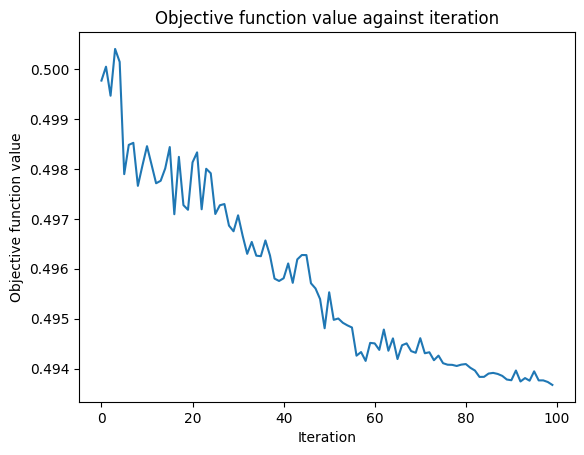

In [9]:
total_time = 0
start_time = time.time()
sampler_classifier.fit(train_sequences, train_labels)
end_time = time.time()
epoch_time = end_time - start_time
total_time += epoch_time

In [10]:
print(f"Total training time: {total_time:.2f} seconds")

Total training time: 14890.35 seconds


In [11]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# from sklearn.metrics import classification_report
# # predictions = sampler_classifier.predict(test_sequences[3000:4000])
# # true_labels = test_labels[3000:4000]


# import pandas as pd

# # # Create a pandas DataFrame with the true values and predictions
# # df = pd.DataFrame({
# #   'True Value': true_labels,
# #   'Prediction': predictions
# # })
# # # Save the DataFrame to a CSV file
# # df.to_csv('QSVC_Z_prediction_results.csv',mode='a', index=False)
# df = pd.read_csv('QSVC_Z_prediction_results.csv')

# true_labels = df["True Value"]
# print(true_labels)
# predictions = df["Prediction"]
# print(predictions)
# # Calculate Accuracy
# accuracy = accuracy_score(true_labels, predictions)
# print(f"Accuracy: {accuracy:.4f}")

# # Calculate Precision and Recall
# precision = precision_score(true_labels, predictions, average='weighted')
# recall = recall_score(true_labels, predictions,average='weighted')
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")

# # Calculate F1-Score
# f1 = f1_score(true_labels, predictions,average=None)
# print(f"F1 Score: {f1:.4f}")

# # Calculate ROC-AUC Score
# # Since it's a binary classification, directly pass the true labels and predictions
# roc_auc = roc_auc_score(true_labels, predictions)
# print(f"ROC-AUC Score: {roc_auc:.4f}")

# # Generate a full classification report
# report = classification_report(true_labels, predictions)
# print("Classification Report:\n", report)

In [12]:
df_test = pd.DataFrame(objective_func_vals)
df_test.to_csv('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/obj_fun_val_QNN_pauli.csv', index=False)
data = pd.read_csv('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/obj_fun_val_QNN_pauli.csv')
print(data.head())

          0
0  0.499771
1  0.500050
2  0.499468
3  0.500406
4  0.500145


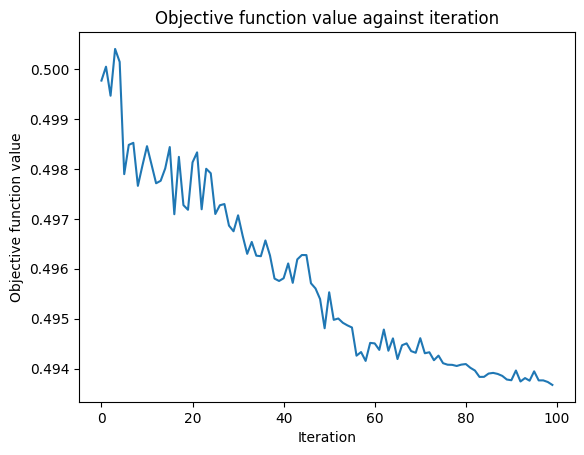

In [13]:
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(data)), data)
plt.show()